0.1601692265619509


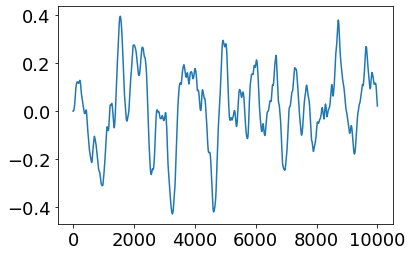

In [ ]:

#1 DEFINE CONNECTIVITY AND INPUTS

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy import signal
from scipy.fft import fftshift

import networkx as nx
import numpy as np
import pandas as pd

T =10000
dt=0.1
N=100
d=-1
beta=50
D =0.000

B=-0.05 #-0.05
rho =0.05 #connectoin probability
f=0.8#proportion of e vs i cells/cortical
sigma_e_2 = 0.005
sigma_i_2 = 0.005
#AXEL: INCREASE MU_E TO INCREASE INSTABILITY AND FLUCTUATIONS AMPLITUDE
mu_e= 0.08 #0.08 so that the variance scales like 1/N
mu_i= -f/(1-f)*mu_e



#arrays for network dynamics
u = np.zeros((N,T))
v = np.zeros((N,T))
time=np.arange(0,T,1)
Spikes_homo = np.zeros((N,T))
Spikes_hetero = np.zeros((N,T))
mean_u = np.zeros(T)
mean_v = np.zeros(T)
#environmental perturbations
perturbations = np.zeros(T)
perturbations[0] =0
filtered_noise_1 = np.zeros(T)
filtered_noise_2 = np.zeros(T)
filtered_noise_3 = np.zeros(T)
Noise=0.7 #0.2
for t in range(len(time)-1):
  perturbations[t+1] = perturbations[t]+dt*(-perturbations[t]+filtered_noise_1[t])
  filtered_noise_1[t+1]= filtered_noise_1[t]+dt*0.1*(-1*filtered_noise_1[t]+filtered_noise_2[t])
  filtered_noise_2[t+1]= filtered_noise_2[t]+dt*0.1*(-1*filtered_noise_2[t]+filtered_noise_3[t])
  filtered_noise_3[t+1]= filtered_noise_3[t]+dt*(-1*filtered_noise_3[t])+np.sqrt(2*Noise*dt)*np.random.normal(0,1)



W = np.zeros((N,N))
M_e=np.random.normal(mu_e, np.sqrt(sigma_e_2), size=(N,N))
M_i=np.random.normal(mu_i, np.sqrt(sigma_i_2), size=(N,N))

List = np.zeros(N);
for i in range(N):
  for j in range(N):
    P_connectivity = np.random.rand()
    if (P_connectivity<rho):
      if (j<int(f*N)):
        List[j] = M_e[i][j];
      else:
        List[j] = M_i[i][j];
    else:
      List[j] = 0;
  np.random.shuffle(List)
  for j in range(N):
    if i==j:
      W[i][j]=0
    else:
      W[i][j]=List[j]
row_sum=np.zeros(N)
for i in range(N):
  row_sum[i] =(np.sum(W[i][:]))
  number_of_nonzero_entries=0
  for j in range(N):
    if W[i][j]!=0:
      number_of_nonzero_entries = number_of_nonzero_entries+1
  for j in range(N):
    if W[i][j]!=0:
      W[i][j]=W[i][j]-row_sum[i]/number_of_nonzero_entries



#variance connectivity matrix - scales like 1/N by construction
plt.plot(time, perturbations)
sigma_2 = rho*(f*sigma_e_2+(1-f)*sigma_i_2+f/(1-f)*mu_e**2)
# print(W)
# print(np.var(W),sigma_2)
# print(np.mean(W))
# for i in range(N):
#   print(np.sum(W[i][:]))

# W = np.zeros((N,N))


# plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
# plt.ylim(-1.5, 1.5)
# plt.show()
print(np.sqrt(np.var(perturbations)))


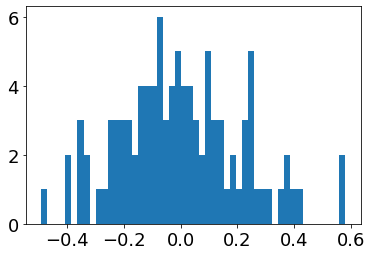

[-0.49316985 -0.39718844 -0.39263626 -0.36197587 -0.36166078 -0.34956196
 -0.32904428 -0.32808283 -0.28540955 -0.27551212 -0.24878943 -0.24280995
 -0.23870919 -0.2231165  -0.21835373 -0.21710861 -0.20214568 -0.19409498
 -0.19344307 -0.19158348 -0.17354784 -0.17102792 -0.1652577  -0.1608365
 -0.14010617 -0.13310879 -0.13295947 -0.13295569 -0.11821137 -0.11804466
 -0.11578331 -0.11249907 -0.10421754 -0.1023503  -0.10113027 -0.09705166
 -0.08338122 -0.083097   -0.07728638 -0.073628   -0.06974164 -0.06730864
 -0.05568315 -0.04983356 -0.04764532 -0.04049178 -0.02772096 -0.0226624
 -0.02202869 -0.01627872 -0.00978639 -0.00662096 -0.00425678  0.
  0.00457456  0.00859936  0.01131202  0.01370713  0.02686667  0.03301946
  0.03769435  0.04365975  0.0518398   0.05586567  0.05617551  0.06900846
  0.07308457  0.08892467  0.09180463  0.09765116  0.09847135  0.10037738
  0.11463469  0.12157613  0.12711311  0.14013799  0.14432938  0.15086686
  0.16973727  0.17931443  0.17992014  0.19505959  0.22149471 

In [ ]:
#2 NETWORK DYNAMICS

sigma_h=0.05#0.1
#resonse function of neurons
def F(u,h):
  output =0.5*(1+special.erf(beta*(u+h)))#np.tanh(beta*u)# 1/(1+np.exp(-beta*u))
  return output


threshold = np.zeros(N)

#Euler integration
for i in range(N):
  u[i][0] = 0.05*np.random.normal(0,1)
  v[i][0] = 0.05*np.random.normal(0,1)
  threshold[i] = np.sqrt(sigma_h)*np.random.normal(0,1)
# threshold = np.arange(-0.5,0.5,1/(N))
threshold.sort()
for i in range(N-1):
  if threshold[i+1]*threshold[i]<0:
    k = i+1
    threshold[k]=0
plt.hist(threshold, bins=50)
plt.show()
print(threshold)
print(k,threshold[k])
for t in range(T-1):
  mean_u[t]=0
  mean_v[t]=0
  for i in range(N):
    sum_homo=0
    sum_hetero= 0

    for j in range(N):
      sum_homo=sum_homo+W[i][j]*F(u[j][t],0)
      sum_hetero = sum_hetero + W[i][j]*F(v[j][t],threshold[j])

    u[i][t+1] = u[i][t] +dt*(d*u[i][t]+sum_homo+perturbations[t]+B)
    v[i][t+1] = v[i][t] +dt*(d*v[i][t]+sum_hetero+perturbations[t]+B)
    mean_u[t] = mean_u[t]+1/N*(u[i][t]-perturbations[t])
    mean_v[t] =  mean_u[t]+1/N*(v[i][t]-perturbations[t])

    prob_homo = np.random.uniform(0,1)
    prob_hetero = np.random.uniform(0,1)
    if (prob_homo<(1-np.exp(-F(u[i][t], 0)*dt))):
      Spikes_homo[i][t]=1/dt
    else:
      Spikes_homo[i][t]=0;

    if (prob_hetero<(1-np.exp(-F(v[i][t], threshold[i])*dt))):
      Spikes_hetero[i][t]=1/dt
    else:
      Spikes_hetero[i][t]=0;


#computing spike traines and firing rates

neuron_homo =[]
spiketime_homo = []
neuron_hetero =[]
spiketime_hetero = []
# Sample = np.array([0,1,2,3,4,5,6,77,88,33,22,12,3,5,6])
t_window=50
firing_rate_homo = np.zeros((N,T))
firing_rate_hetero = np.zeros((N,T))

for t in range(len(time)-t_window):
  for i in range(N):
    for s in range(t_window):
      if (Spikes_homo[i][t-int(t_window/2)+s]>0.1):
        firing_rate_homo[i][t+int(t_window/2)]=firing_rate_homo[i][t+int(t_window/2)]+1/(t_window*dt)
for t in range(len(time)-1):
  for i in range(N):
    if (Spikes_homo[i][t]>0.1):
      neuron_homo.append(i)
      spiketime_homo.append(t)

for t in range(len(time)-t_window):
  for i in range(N):
    for s in range(t_window):
      if (Spikes_hetero[i][t-int(t_window/2)+s]>0.1):
        firing_rate_hetero[i][t+int(t_window/2)]=firing_rate_hetero[i][t+int(t_window/2)]+1/(t_window*dt)
for t in range(len(time)-1):
  for i in range(N):
    if (Spikes_hetero[i][t]>0.1):
      neuron_hetero.append(i)
      spiketime_hetero.append(t)


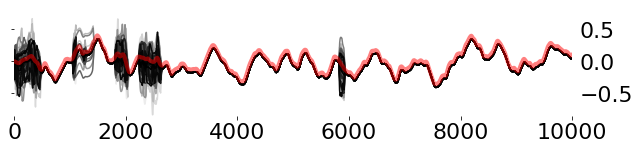

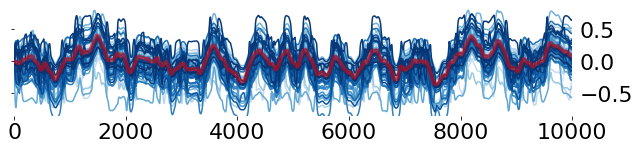

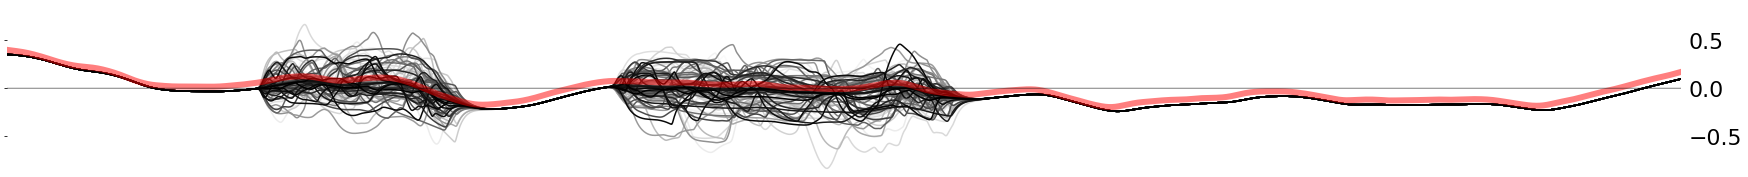

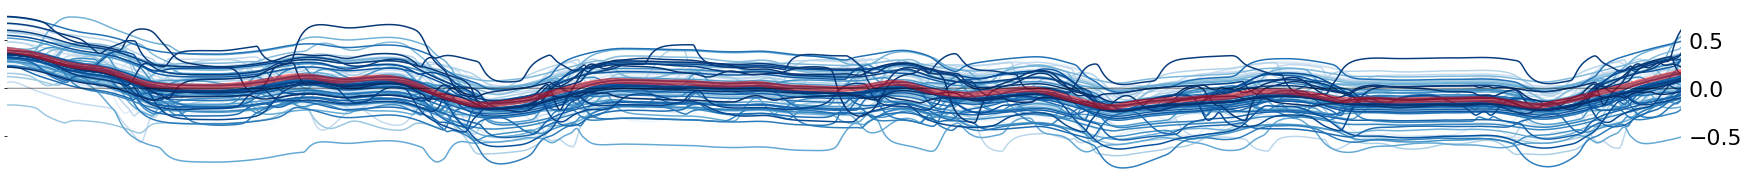

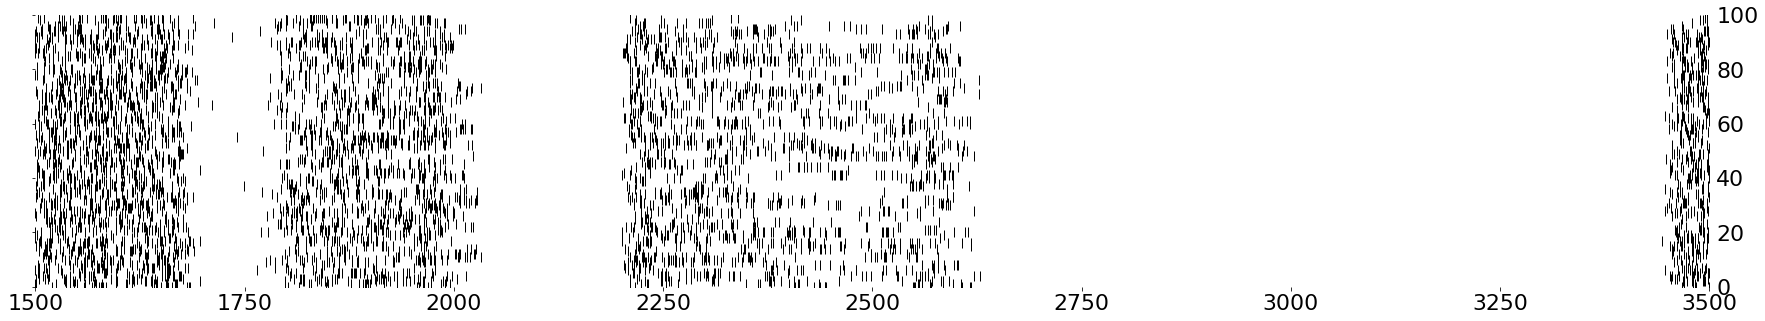

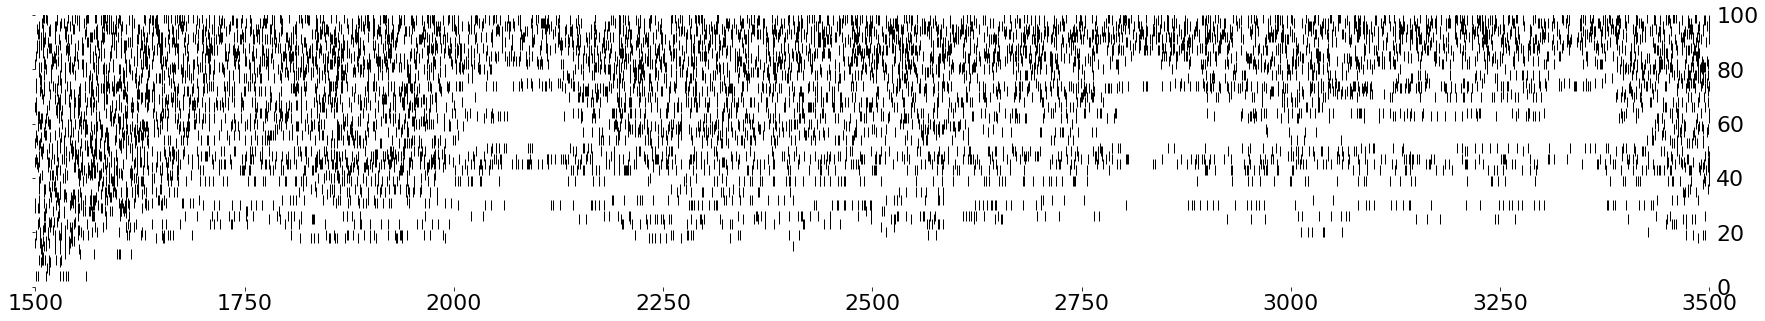

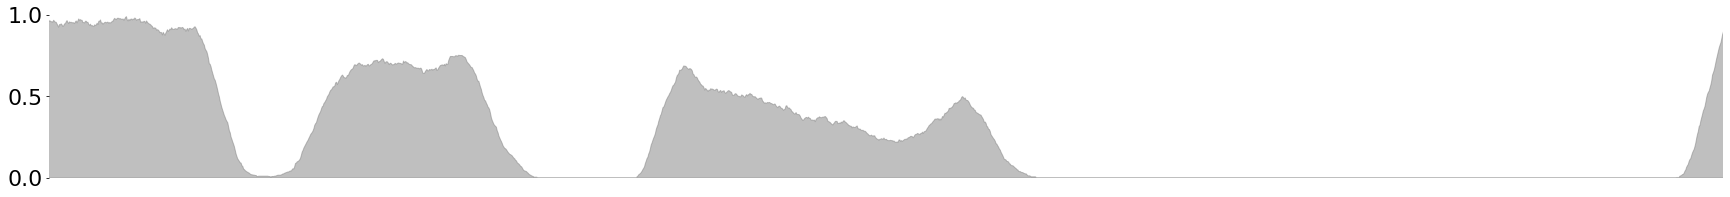

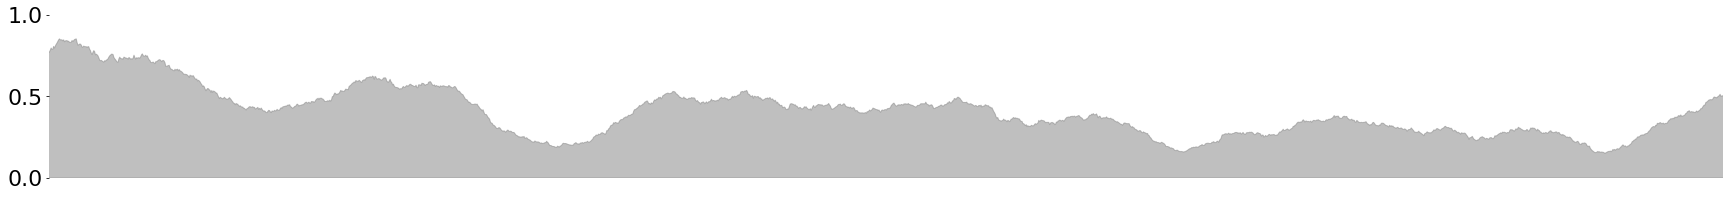

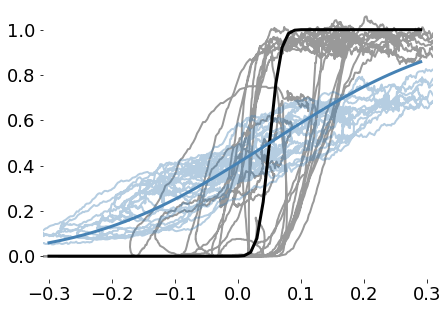

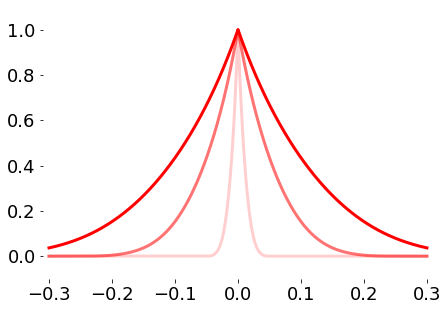

In [ ]:
#3 PLOTTING COMMANDS

t1 =1500
t2 = 3500

#plotting network dynamics




# colormap = plt.cm.gist_ncar
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
# for i in range(N):
#     plt.plot(time,F(u[i][:],threshold[i]))
# plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
# # plt.ylim(-0.5, 1.5)
# plt.xlim(0, T)
# # plt.xlim(T/2-1, T/2+30)
# plt.show()

#plot temporal deviations
# mu_u=np.zeros(N)
# deviation = np.zeros(T)
# mu_perturbation = np.mean(perturbations[:])
# for i in range(N):
#   mu_u[i]=np.mean(u[i][:])-mu_perturbation
# for t in range(T):
#   for i in range(N):
#     deviation[t] = deviation[t]+1/N*np.abs(u[i][t]-mu_u[i]-perturbations[t])
# plt.plot(time,deviation, color='red',  linewidth=4, alpha=0.5)
# plt.ylim(0, 0.20)
# plt.show()


#plot spectrogram
# x = u[23][:]
# f, t, Sxx = signal.spectrogram(x, 1e3)
# plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.ylim(0, 200)
# plt.show()

# colormap = plt.cm.gist_ncar
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greens(np.linspace(0, 1, N))))
# for i in range(N):
#     plt.plot(time,v[i][:])
# plt.ylim(-1.5, 1.5)
# plt.show()




#plotting spike trains
# neuron =[]
# spiketime = []
# t_window=50
# for t in range(len(time)-t_window):
#   for i in range(N):
#     for s in range(t_window):
#       if (Spikes[i][t-int(t_window/2)+s]>0.1):
#         firing_rate[i][t+int(t_window/2)]=firing_rate[i][t+int(t_window/2)]+1/t_window
# for t in range(len(time)-1):
#   for i in range(N):
#     if (Spikes[i][t]>0.1):
#       neuron.append(i)
#       spiketime.append(t*dt)


# plt.plot(spiketime,neuron,'|');
# plt.show()


# mean_firing_rate = np.zeros(T)
# colormap = plt.cm.gist_ncar
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greens(np.linspace(0, 1, N))))
# for t in range(len(time)-1):
#   for i in range(N):
#     mean_firing_rate[t] = mean_firing_rate[t] +1/N*firing_rate[i][t]
# plt.plot(time,mean_firing_rate, color="black")
# for i in range(N):
#     plt.plot(time,firing_rate[i][:], alpha=0.15)
# plt.show()

# Spectral_radius_in_time = np.zeros(len(time))
# Spectral_radius_theo_in_time =  np.zeros(len(time))
# for t in range(len(time)):
#   J_o = np.zeros((N,N))
#   for i in range(N):
#     for j in range(N):
#       J_o[i][j] = W[i][j]*beta/np.sqrt(np.pi)*np.exp(-beta**2*(perturbations[t])**2)
#   Var_J_o = np.var(J_o)
#   Spectral_radius_in_time[t] = np.sqrt(N*Var_J_o)
#   Spectral_radius_theo_in_time[t] = np.sqrt(N*sigma_2*beta**2/(np.pi*np.sqrt(4*0*beta**2+1))*(np.exp(-beta**2*(perturbations[t])**2))**2)
# plt.rcParams.update({'font.size': 22})
# for pos in ['right', 'top', 'bottom', 'left']:
#    plt.gca().spines[pos].set_visible(False)
# plt.plot(time,Spectral_radius_in_time,color="blue",linewidth=4)
# plt.plot(time,Spectral_radius_theo_in_time,color="blue",linewidth=2,alpha=0.4)
# plt.plot(time,np.ones(len(time)),color='k',linestyle="--")
# plt.show()

###################FULL TIME DYNAMICS S##########################

plt.figure(figsize=(10,2))
plt.rcParams.update({'font.size': 22})
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,u[i][:])
plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
plt.ylim(-0.85, 0.85)
plt.xlim(0, T)
# plt.xlim(T/2-1, T/2+30)
plt.show()

plt.figure(figsize=(10,2))
plt.rcParams.update({'font.size': 22})
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,v[i][:])
plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
plt.ylim(-0.85, 0.85)
plt.xlim(0, T)
# plt.xlim(T/2-1, T/2+30)
plt.show()



###################CLOSE UP DYNAMICS S##########################

plt.figure(figsize=(30,3))
plt.rcParams.update({'font.size': 22})
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,u[i][:])
plt.plot(time,perturbations, color='red',  linewidth=6, alpha=0.5)
plt.plot(time,0*np.ones(len(time)), color='black',  linewidth=1, alpha=0.5)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
x_ticks = np.arange(400,650,50)  # Set label locations.
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.ylim(-0.85, 0.85)
plt.xlim(t1,t2)
plt.xticks([])
# plt.xlim(T/2-1, T/2+30)
plt.show()

plt.figure(figsize=(30,3))
plt.rcParams.update({'font.size': 22})
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,v[i][:])
plt.plot(time,perturbations, color='red',  linewidth=6, alpha=0.5)
plt.plot(time,0*np.ones(len(time)), color='black',  linewidth=1, alpha=0.5)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
x_ticks = np.arange(400,650,50)  # Set label locations.
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.ylim(-0.85, 0.85)
plt.xlim(t1,t2)
plt.xticks([])
# plt.xlim(T/2-1, T/2+30)
plt.show()





###################SPIKE TRAINS##########################


plt.figure(figsize=(30,5))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 22})
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.plot(spiketime_homo,neuron_homo,'|', markersize=10,  linewidth=40,color = 'black')
# plt.plot(time,50*perturbations+0, color='red',  linewidth=4, alpha=0.5)

plt.xlim(t1,t2)
plt.ylim(0,N)
# plt.xlim(T/2-1, T/2+30)
# plt.show()

plt.figure(figsize=(30,5))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 22})
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.plot(spiketime_hetero,neuron_hetero,'|', markersize=10,  linewidth=40,color = 'black')
# plt.plot(time,50*perturbations+0, color='red',  linewidth=4, alpha=0.5)

plt.xlim(t1,t2)
plt.ylim(0,N)
# plt.show()

###################FIRING RATESS##########################

mean_firing_rate_homo = np.zeros(T)
plt.figure(figsize=(30,3))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 22})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
for t in range(len(time)-1):
  for i in range(N):
    mean_firing_rate_homo[t] = mean_firing_rate_homo[t] +1/N*firing_rate_homo[i][t]
plt.fill_between(time,mean_firing_rate_homo, color="grey", alpha=0.5)
# plt.plot(time,perturbations, color="black")
# for i in range(N):
#     plt.plot(time,firing_rate[i][:], alpha=0.15)
plt.xlim(t1,t2)
plt.ylim(0,1)
plt.xticks([])
# plt.xlim(T/2-1, T/2+30)
plt.show()

mean_firing_rate_hetero = np.zeros(T)
plt.figure(figsize=(30,3))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 22})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
for t in range(len(time)-1):
  for i in range(N):
    mean_firing_rate_hetero[t] = mean_firing_rate_hetero[t] +1/N*firing_rate_hetero[i][t]
plt.fill_between(time,mean_firing_rate_hetero, color="grey", alpha=0.5)
# plt.plot(time,perturbations, color="black")
# for i in range(N):
#     plt.plot(time,firing_rate[i][:], alpha=0.15)
plt.xlim(t1,t2)
plt.ylim(0,1)
plt.xticks([])
# plt.xlim(T/2-1, T/2+30)
plt.show()

###################RESPONSE FUNCTIONS##########################

Stim = np.arange(-0.3, 0.3, 0.01)
plt.figure(figsize=(7,5))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 18})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.plot(perturbations[50:T-50], mean_firing_rate_homo[50:T-50], alpha=0.4,linewidth=2, color = 'black')
plt.plot(perturbations[50:T-50], mean_firing_rate_hetero[50:T-50], alpha=0.4,linewidth=2, color = 'steelblue')
plt.plot(Stim, 1/2*(1+special.erf(beta*(Stim+B)/np.sqrt(1+2*beta**2*0))), color='black', linewidth=3)
plt.plot(Stim, 1/2*(1+special.erf(beta*(Stim+B)/np.sqrt(1+2*beta**2*sigma_h))), color='steelblue', linewidth=3)
plt.ylim(-0.1, 1.1)
plt.xlim(-0.31, 0.31)
plt.xticks([-0.3,-0.2,-0.1, 0, 0.1, 0.2, 0.3])
plt.show()


###################CORREALTIONS##########################


plt.figure(figsize=(7,5))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 18})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
delta = np.arange(-0.3,0.3, 0.0001)
corr = np.zeros(len(delta))
Perturbation = [0.01, 0.05, 0.1]
cg = 5000000
y = np.arange(0,1,1/len(delta))
for So in Perturbation:
  k_alpha = 9*So+0.1
  for i in range(len(delta)):
    corr[i] =  4 * (0.1e1 / 0.4e1 + special.erf(cg * min(0, delta[i]) * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2 - special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 4) * (1 - 2 * (np.pi ** 2 * So ** 2 * cg ** 2 + 4) ** (-0.1e1 / 0.2e1)) ** (-0.1e1 / 0.2e1) * (2 + 2 * special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) - 2 * np.exp(-np.pi ** 2 * cg ** 2 * delta[i] ** 2 / (2 * np.pi ** 2 * So ** 2 * cg ** 2 + 8)) * (np.pi ** 2 * So ** 2 * cg ** 2 + 4+0.0001) ** (-0.1e1 / 0.2e1) - 4 * (0.1e1 / 0.2e1 + special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2) ** 2+0.0001) ** (-0.1e1 / 0.2e1)
  plt.plot(delta, corr, linewidth=3, color = 'red',alpha=k_alpha)
plt.ylim(-0.1, 1.1)
plt.xlim(-0.31, 0.31)
plt.xticks([-0.3,-0.2,-0.1, 0, 0.1, 0.2, 0.3])
plt.show()


# mean_firing_rate = np.zeros(T)
# colormap = plt.cm.gist_ncar
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greens(np.linspace(0, 1, N))))
# for i in range(N):
#     plt.plot(perturbations, F(u[i][:], threshold[i]), alpha=0.05)
# plt.show()

# for i in range(N):
#     plt.plot(perturbations,firing_rate[i][:], alpha=0.15, color='blue')



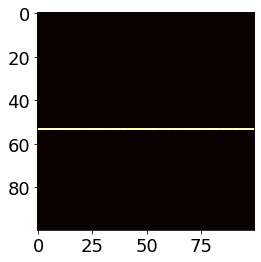

0.009344211293954331


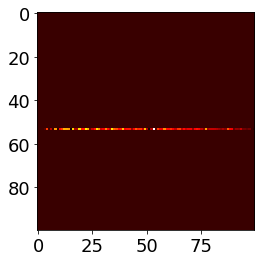

In [ ]:
#CORRELATION ANALYSIS BASED  ON SINGLE TRIAL (PREVIOUS CODE CELL)
Corr_homo = np.zeros((N,N))
Corr_hetero = np.zeros((N,N))
T1 = 0
T2 = T



# for i in range(N):
#   for j in range(N):
#     data_1 = np.zeros(T)
#     data_2 = np.zeros(T)
#     data_3 = np.zeros(T)
#     data_4 = np.zeros(T)
#     for t in range(T1,T2):
#       # data_1[t] =  firing_rate_homo[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       # data_2[t] =  firing_rate_homo[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       # data_3[t] =  firing_rate_hetero[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       # data_4[t] =  firing_rate_hetero[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       data_1[t] =  F(u[i][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       data_2[t] =  F(u[j][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       data_3[t] =  F(v[i][t], threshold[i])+np.sqrt(2*0.0001)*np.random.normal(0,1)
#       data_4[t] =  F(v[j][t], threshold[j])+np.sqrt(2*0.0001)*np.random.normal(0,1)
#     Corr_homo[i][j] = np.corrcoef(data_1, data_2)[0, 1]
#     Corr_hetero[i][j] = np.corrcoef(data_3,data_4)[0,1]
# plt.imshow(Corr_homo, cmap='hot', interpolation='nearest')
# plt.show()
# plt.imshow(Corr_hetero, cmap='hot', interpolation='nearest')
# print(np.mean(Corr_homo))
# plt.show()



for j in range(N):
  data_1 = np.zeros(T)
  data_2 = np.zeros(T)
  data_3 = np.zeros(T)
  data_4 = np.zeros(T)
  for t in range(T1,T2):
      # data_1[t] =  firing_rate_homo[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_2[t] =  firing_rate_homo[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_3[t] =  firing_rate_hetero[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_4[t] =  firing_rate_hetero[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
    data_1[t] =  F(u[k][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
    data_2[t] =  F(u[j][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
    data_3[t] =  F(v[k][t], threshold[k])+np.sqrt(2*0.0001)*np.random.normal(0,1)
    data_4[t] =  F(v[j][t], threshold[j])+np.sqrt(2*0.0001)*np.random.normal(0,1)
  Corr_homo[k][j] = np.corrcoef(data_1, data_2)[0, 1]
  Corr_hetero[k][j] = np.corrcoef(data_3,data_4)[0,1]
# plt.imshow(Corr_homo, cmap='hot', interpolation='nearest')
# plt.show()
# plt.imshow(Corr_hetero, cmap='hot', interpolation='nearest')
# print(np.mean(Corr_homo))
# plt.show()


In [ ]:

#CORRELATION ANALYSIS BASED  ON SINGLE TRIAL (PREVIOUS CODE CELL)
# Net_corr_homo =[]
# Net_corr_hetero = []
# Delta_h = []
# # for i in range(N):
# #   for j in range(N):
# #     Net_corr_homo.append(Corr_homo[i][j])
# #     Net_corr_hetero.append(Corr_hetero[i][j])
# #     Delta_h.append(threshold[j]-threshold[i])
# for j in range(N):
#   Net_corr_homo.append(Corr_homo[k][j])
#   Net_corr_hetero.append(Corr_hetero[k][j])
#   Delta_h.append(threshold[j]-threshold[k])

# delta = np.arange(-0.3,0.3, 0.0001)
# corr = np.zeros(len(delta))
# cg = 5000000
# So=np.sqrt(np.var(perturbations))
# for i in range(len(delta)):
#     corr[i] =  4 * (0.1e1 / 0.4e1 + special.erf(cg * min(0, delta[i]) * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2 - special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 4) * (1 - 2 * (np.pi ** 2 * So ** 2 * cg ** 2 + 4) ** (-0.1e1 / 0.2e1)) ** (-0.1e1 / 0.2e1) * (2 + 2 * special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) - 2 * np.exp(-np.pi ** 2 * cg ** 2 * delta[i] ** 2 / (2 * np.pi ** 2 * So ** 2 * cg ** 2 + 8)) * (np.pi ** 2 * So ** 2 * cg ** 2 + 4+0.0001) ** (-0.1e1 / 0.2e1) - 4 * (0.1e1 / 0.2e1 + special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2) ** 2+0.0001) ** (-0.1e1 / 0.2e1)

# plt.plot(delta, corr)
# plt.scatter(Delta_h, Net_corr_homo, color='black')
# plt.scatter(Delta_h, Net_corr_hetero, color='blue')
# plt.xlim(-0.5,0.5)
# plt.show()

IndexError: ignored

In [ ]:

#CORRELATION ANALYSIS FULL CONNECTIONS (takes 4hrs, beware!)


#reference data
#N=100
#beta =50
# f=0.8
# sigma_e_2 = 0.005
# sigma_i_2 = 0.005
# mu_e= 0.08
# mu_i= -f/(1-f)*mu_e


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy import signal
from scipy.fft import fftshift

import networkx as nx
import numpy as np
import pandas as pd

N= 100
T = 10000
Q = 20#trials
dt=0.1
B=-.05
sigma_h = 0.05

u = np.zeros((N,T))
v = np.zeros((N,T))
time=np.arange(0,T,1)

#resonse function of neurons
def F(u,h):
  output =0.5*(1+special.erf(beta*(u+h)))#np.tanh(beta*u)# 1/(1+np.exp(-beta*u))
  return output

Corr_homo = np.zeros((N,Q))
Corr_hetero = np.zeros((N,Q))
T1 = 0
T2 = T
threshold = np.zeros(N)
for i in range(N):
  threshold[i] = np.sqrt(sigma_h)*np.random.normal(0,1)
threshold.sort()
for i in range(N-1):
  if threshold[i+1]*threshold[i]<0:
    k = i+1
    threshold[k]=0
mean_So=0
for q in range(Q):
    N= 100
    d=-1
    beta=50
    D =0.000
    rho =0.05 #connectoin probability
    f=0.8#proportion of e vs i cells/cortical
    sigma_e_2 = 0.005
    sigma_i_2 = 0.005
    #AXEL: INCREASE MU_E TO INCREASE INSTABILITY AND FLUCTUATIONS AMPLITUDE
    mu_e= 0.08 #0.08 so that the variance scales like 1/N
    mu_i= -f/(1-f)*mu_e

    W = np.zeros((N,N))
    M_e=np.random.normal(mu_e, np.sqrt(sigma_e_2), size=(N,N))
    M_i=np.random.normal(mu_i, np.sqrt(sigma_i_2), size=(N,N))

    List = np.zeros(N);
    for i in range(N):
      for j in range(N):
        P_connectivity = np.random.rand()
        if (P_connectivity<rho):
          if (j<int(f*N)):
            List[j] = M_e[i][j];
          else:
            List[j] = M_i[i][j];
        else:
          List[j] = 0;
      np.random.shuffle(List)
      for j in range(N):
        if i==j:
          W[i][j]=0
        else:
          W[i][j]=List[j]
    row_sum=np.zeros(N)
    for i in range(N):
      row_sum[i] =(np.sum(W[i][:]))
      number_of_nonzero_entries=0
      for j in range(N):
        if W[i][j]!=0:
          number_of_nonzero_entries = number_of_nonzero_entries+1
      for j in range(N):
        if W[i][j]!=0:
          W[i][j]=W[i][j]-row_sum[i]/number_of_nonzero_entries
    u = np.zeros((N,T))
    v = np.zeros((N,T))
    filtered_noise_1 = np.zeros(T)
    filtered_noise_2 = np.zeros(T)
    filtered_noise_3 = np.zeros(T)
    time=np.arange(0,T,1)
    perturbations = np.zeros(T)
    Noise=0.2
    for t in range(len(time)-1):
      perturbations[t+1] = perturbations[t]+dt*(-perturbations[t]+filtered_noise_1[t])
      filtered_noise_1[t+1]= filtered_noise_1[t]+dt*0.1*(-1*filtered_noise_1[t]+filtered_noise_2[t])
      filtered_noise_2[t+1]= filtered_noise_2[t]+dt*0.1*(-1*filtered_noise_2[t]+filtered_noise_3[t])
      filtered_noise_3[t+1]= filtered_noise_3[t]+dt*(-1*filtered_noise_3[t])+np.sqrt(2*Noise*dt)*np.random.normal(0,1)

    mean_So = mean_So + 1/Q*np.sqrt(np.var(perturbations))

    #Euler integration
    for i in range(N):
      u[i][0] = 0.05*np.random.normal(0,1)
      v[i][0] = 0.05*np.random.normal(0,1)


    for t in range(T-1):
      for i in range(N):
        sum_homo=0
        sum_hetero=0
        for j in range(N):
          sum_homo=sum_homo+W[i][j]*F(u[j][t],0)
          sum_hetero=sum_hetero+W[i][j]*F(v[j][t],threshold[j])
        u[i][t+1] = u[i][t] +dt*(d*u[i][t]+sum_homo+perturbations[t]+B)
        v[i][t+1] = v[i][t] +dt*(d*v[i][t]+sum_hetero+perturbations[t]+B)
    for j in range(N):
      data_1 = np.zeros(T)
      data_2 = np.zeros(T)
      data_3 = np.zeros(T)
      data_4 = np.zeros(T)
      for t in range(T1,T2):
      # data_1[t] =  firing_rate_homo[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_2[t] =  firing_rate_homo[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_3[t] =  firing_rate_hetero[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_4[t] =  firing_rate_hetero[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_1[t] =  F(u[k][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_2[t] =  F(u[j][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_3[t] =  F(v[k][t], threshold[k])+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_4[t] =  F(v[j][t], threshold[j])+np.sqrt(2*0.0001)*np.random.normal(0,1)
      Corr_homo[j][q] = np.corrcoef(data_1, data_2)[0, 1]
      Corr_hetero[j][q] = np.corrcoef(data_3,data_4)[0,1]
    print(q)









0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:

#CORRELATION ANALYSIS OVER TRIALS NO CONNECTIONS!!!!!!!!!!!!!


#reference data
#N=100
#beta =50
# f=0.8
# sigma_e_2 = 0.005
# sigma_i_2 = 0.005
# mu_e= 0.08
# mu_i= -f/(1-f)*mu_e


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy import signal
from scipy.fft import fftshift

import networkx as nx
import numpy as np
import pandas as pd

N= 100
T = 10000
Q = 20#trials
dt=0.1
B=-.05
sigma_h = 0.05

u = np.zeros((N,T))
v = np.zeros((N,T))
time=np.arange(0,T,1)

#resonse function of neurons
def F(u,h):
  output =0.5*(1+special.erf(beta*(u+h)))#np.tanh(beta*u)# 1/(1+np.exp(-beta*u))
  return output

Corr_homo_o = np.zeros((N,Q))
Corr_hetero_o = np.zeros((N,Q))
T1 = 0
T2 = T
threshold_o = np.zeros(N)
for i in range(N):
  threshold_o[i] = np.sqrt(sigma_h)*np.random.normal(0,1)
threshold_o.sort()
for i in range(N-1):
  if threshold_o[i+1]*threshold_o[i]<0:
    k = i+1
    threshold_o[k]=0
mean_So_o=0
for q in range(Q):
    N= 100
    d=-1
    beta=50
    D =0.000
    rho =0.05 #connectoin probability
    f=0.8#proportion of e vs i cells/cortical
    sigma_e_2 = 0.005
    sigma_i_2 = 0.005
    #AXEL: INCREASE MU_E TO INCREASE INSTABILITY AND FLUCTUATIONS AMPLITUDE
    mu_e= 0.08 #0.08 so that the variance scales like 1/N
    mu_i= -f/(1-f)*mu_e

    W = np.zeros((N,N))
    M_e=np.random.normal(mu_e, np.sqrt(sigma_e_2), size=(N,N))
    M_i=np.random.normal(mu_i, np.sqrt(sigma_i_2), size=(N,N))

    List = np.zeros(N);
    for i in range(N):
      for j in range(N):
        P_connectivity = np.random.rand()
        if (P_connectivity<rho):
          if (j<int(f*N)):
            List[j] = M_e[i][j];
          else:
            List[j] = M_i[i][j];
        else:
          List[j] = 0;
      np.random.shuffle(List)
      for j in range(N):
        if i==j:
          W[i][j]=0
        else:
          W[i][j]=List[j]
    row_sum=np.zeros(N)
    for i in range(N):
      row_sum[i] =(np.sum(W[i][:]))
      number_of_nonzero_entries=0
      for j in range(N):
        if W[i][j]!=0:
          number_of_nonzero_entries = number_of_nonzero_entries+1
      for j in range(N):
        if W[i][j]!=0:
          W[i][j]=W[i][j]-row_sum[i]/number_of_nonzero_entries
    u = np.zeros((N,T))
    v = np.zeros((N,T))
    filtered_noise_1 = np.zeros(T)
    filtered_noise_2 = np.zeros(T)
    filtered_noise_3 = np.zeros(T)
    time=np.arange(0,T,1)
    perturbations = np.zeros(T)
    Noise=0.2
    for t in range(len(time)-1):
      perturbations[t+1] = perturbations[t]+dt*(-perturbations[t]+filtered_noise_1[t])
      filtered_noise_1[t+1]= filtered_noise_1[t]+dt*0.1*(-1*filtered_noise_1[t]+filtered_noise_2[t])
      filtered_noise_2[t+1]= filtered_noise_2[t]+dt*0.1*(-1*filtered_noise_2[t]+filtered_noise_3[t])
      filtered_noise_3[t+1]= filtered_noise_3[t]+dt*(-1*filtered_noise_3[t])+np.sqrt(2*Noise*dt)*np.random.normal(0,1)

    mean_So_o = mean_So_o + 1/Q*np.sqrt(np.var(perturbations))
    print(np.sqrt(np.var(perturbations)))

    #Euler integration
    for i in range(N):
      u[i][0] = 0.05*np.random.normal(0,1)
      v[i][0] = 0.05*np.random.normal(0,1)


    for t in range(T-1):
      for i in range(N):
        sum_homo=0
        sum_hetero=0
        # for j in range(N):
        #   sum_homo=sum_homo+W[i][j]*F(u[j][t],0)
        #   sum_hetero=sum_hetero+W[i][j]*F(v[j][t],threshold[j])
        u[i][t+1] = u[i][t] +dt*(d*u[i][t]+0+perturbations[t]+B)
        v[i][t+1] = v[i][t] +dt*(d*v[i][t]+0+perturbations[t]+B)
    for j in range(N):
      data_1 = np.zeros(T)
      data_2 = np.zeros(T)
      data_3 = np.zeros(T)
      data_4 = np.zeros(T)
      for t in range(T1,T2):
      # data_1[t] =  firing_rate_homo[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_2[t] =  firing_rate_homo[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_3[t] =  firing_rate_hetero[i][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
      # data_4[t] =  firing_rate_hetero[j][t]+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_1[t] =  F(u[k][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_2[t] =  F(u[j][t], 0)+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_3[t] =  F(v[k][t], threshold_o[k])+np.sqrt(2*0.0001)*np.random.normal(0,1)
        data_4[t] =  F(v[j][t], threshold_o[j])+np.sqrt(2*0.0001)*np.random.normal(0,1)
      Corr_homo_o[j][q] = np.corrcoef(data_1, data_2)[0, 1]
      Corr_hetero_o[j][q] = np.corrcoef(data_3,data_4)[0,1]
    print(q)









0.10614448356745695
0
0.10744823290006507
1
0.11173865336923627
2
0.10186115693526636
3
0.10414433764305618
4
0.10819731808287238
5
0.07941815726995478
6
0.09836079237375445
7
0.08975427561794373
8
0.11114056021703497
9
0.10396916081631795
10
0.08869923360693792
11
0.09405813922045486
12
0.09173199648271312
13
0.10110409341168174
14
0.08210236390868368
15
0.09558520860216899
16
0.09388272327913572
17
0.09494462399966472
18
0.0917567848757341
19


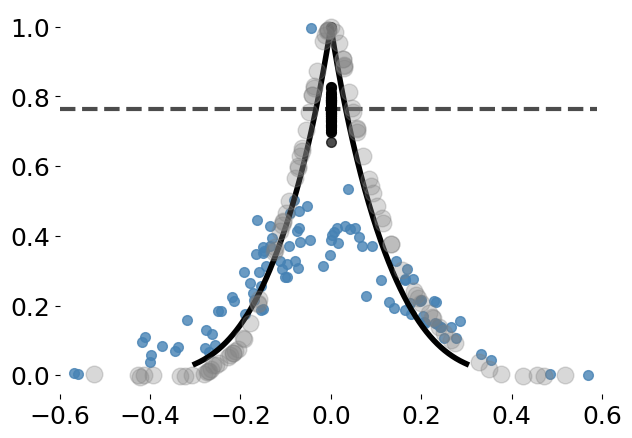

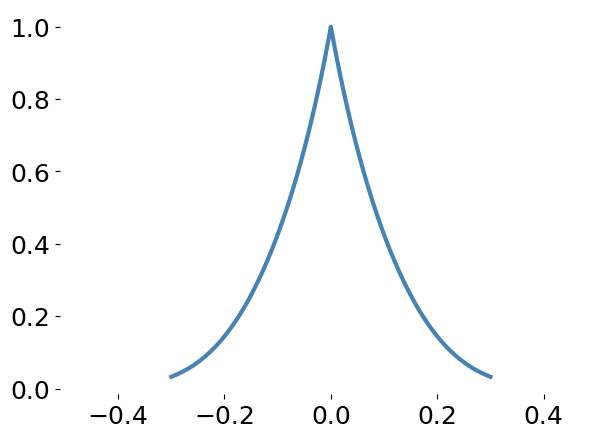

In [ ]:
#no connections
Net_corr_homo_o =[]
Net_corr_hetero_o = []
Delta_h_o = []

Mean_corr_homo_o = np.zeros(N)
Mean_corr_hetero_o= np.zeros(N)
for q in range(Q):
  for j in range(N):
    Mean_corr_homo_o[j] = Mean_corr_homo_o[j] + 1/Q*Corr_homo_o[j][q]
    Mean_corr_hetero_o[j] = Mean_corr_hetero_o[j] + 1/Q*Corr_hetero_o[j][q]

# plt.plot(threshold,Corr_hetero)
for j in range(N):
  Net_corr_homo_o.append(Mean_corr_homo_o[j])
  Net_corr_hetero_o.append(Mean_corr_hetero_o[j])
  Delta_h_o.append(threshold_o[j]-threshold_o[k])

#full connections
Net_corr_homo =[]
Net_corr_hetero = []
Delta_h = []

Mean_corr_homo = np.zeros(N)
Mean_corr_hetero= np.zeros(N)
for q in range(Q):
  for j in range(N):
    Mean_corr_homo[j] = Mean_corr_homo[j] + 1/Q*Corr_homo[j][q]
    Mean_corr_hetero[j] = Mean_corr_hetero[j] + 1/Q*Corr_hetero[j][q]

# plt.plot(threshold,Corr_hetero)
for j in range(N):
  Net_corr_homo.append(Mean_corr_homo[j])
  Net_corr_hetero.append(Mean_corr_hetero[j])
  Delta_h.append(threshold[j]-threshold[k])

delta = np.arange(-0.3,0.3, 0.0001)
corr_o = np.zeros(len(delta))
corr = np.zeros(len(delta))
cg = 5000000
So=mean_So
So_o =mean_So_o
for i in range(len(delta)):
    corr[i] =  4 * (0.1e1 / 0.4e1 + special.erf(cg * min(0, delta[i]) * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2 - special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 4) * (1 - 2 * (np.pi ** 2 * So ** 2 * cg ** 2 + 4) ** (-0.1e1 / 0.2e1)) ** (-0.1e1 / 0.2e1) * (2 + 2 * special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) - 2 * np.exp(-np.pi ** 2 * cg ** 2 * delta[i] ** 2 / (2 * np.pi ** 2 * So ** 2 * cg ** 2 + 8)) * (np.pi ** 2 * So ** 2 * cg ** 2 + 4+0.0001) ** (-0.1e1 / 0.2e1) - 4 * (0.1e1 / 0.2e1 + special.erf(cg * delta[i] * (2 * So ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2) ** 2+0.0001) ** (-0.1e1 / 0.2e1)
    corr_o[i] =  4 * (0.1e1 / 0.4e1 + special.erf(cg * min(0, delta[i]) * (2 * So_o ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2 - special.erf(cg * delta[i] * (2 * So_o ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 4) * (1 - 2 * (np.pi ** 2 * So_o ** 2 * cg ** 2 + 4) ** (-0.1e1 / 0.2e1)) ** (-0.1e1 / 0.2e1) * (2 + 2 * special.erf(cg * delta[i] * (2 * So_o ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) - 2 * np.exp(-np.pi ** 2 * cg ** 2 * delta[i] ** 2 / (2 * np.pi ** 2 * So_o ** 2 * cg ** 2 + 8)) * (np.pi ** 2 * So_o ** 2 * cg ** 2 + 4+0.0001) ** (-0.1e1 / 0.2e1) - 4 * (0.1e1 / 0.2e1 + special.erf(cg * delta[i] * (2 * So_o ** 2 * cg ** 2 + 1) ** (-0.1e1 / 0.2e1)) / 2) ** 2+0.0001) ** (-0.1e1 / 0.2e1)


plt.figure(figsize=(7,5))
Delta_h_range = np.arange(-0.6, 0.6, 1.2/(len(Delta_h)))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 18})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
# plt.plot(delta, corr, linewidth=3, color = 'steelblue',alpha=1)
# plt.plot(Delta_h, Net_corr_homo, 'o',color='Black', markersize=7, alpha=0.7)
plt.plot(np.zeros(len(Delta_h)), Net_corr_homo, 'o',color='Black', markersize=7, alpha=0.7)#new!
plt.plot(Delta_h_range, np.mean(Net_corr_homo)*np.ones(len(Delta_h)),'--', linewidth =3, color='Black', markersize=7, alpha=0.7)#new!
plt.plot(Delta_h, Net_corr_hetero, 'o',color='steelblue',alpha=0.8, markersize=7)
plt.plot(delta, corr_o, linewidth=4, color = 'black',alpha=1)
# plt.plot(Delta_h_o, Net_corr_homo_o, 'o',color='Black', markersize=7, alpha=0.7)
plt.plot(Delta_h_o, Net_corr_hetero_o, 'o',color='grey',alpha=0.3, markersize=12)
plt.xlim(-0.6,0.6)


plt.figure(figsize=(7,5))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 18})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
# plt.plot(delta_o, corr_o, linewidth=3, color = 'steelblue',alpha=1)
plt.plot(delta, corr_o, linewidth=3, color = 'steelblue',alpha=1)

plt.xlim(-0.51,0.51)
plt.show()


In [ ]:

#LYAPUNOV EXPONENTS


#reference data
#N=100
#beta =50
# f=0.8
# sigma_e_2 = 0.005
# sigma_i_2 = 0.005
# mu_e= 0.08
# mu_i= -f/(1-f)*mu_e


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy import signal
from scipy.fft import fftshift

import networkx as nx
import numpy as np
import pandas as pd

N= 100
T = 1000
Q = 150#trials
dt=0.1
B=-.05
sigma_h = 0.05

u = np.zeros((N,T))
v = np.zeros((N,T))
time=np.arange(0,T,1)

#resonse function of neurons
def F(u,h):
  output =0.5*(1+special.erf(beta*(u+h)))#np.tanh(beta*u)# 1/(1+np.exp(-beta*u))
  return output

lyapunov_homo=np.zeros(Q)
lyapunov_hetero=np.zeros(Q)
time_var_lyapunov_homo = np.zeros(Q)
time_var_lyapunov_hetero = np.zeros(Q)
for q in range(Q):
    N= 100
    d=-1
    beta=50
    D =0.000
    rho =0.05 #connectoin probability
    f=0.8#proportion of e vs i cells/cortical
    sigma_e_2 = 0.005
    sigma_i_2 = 0.005
    #AXEL: INCREASE MU_E TO INCREASE INSTABILITY AND FLUCTUATIONS AMPLITUDE
    mu_e= 0.08 #0.08 so that the variance scales like 1/N
    mu_i= -f/(1-f)*mu_e

    W = np.zeros((N,N))
    M_e=np.random.normal(mu_e, np.sqrt(sigma_e_2), size=(N,N))
    M_i=np.random.normal(mu_i, np.sqrt(sigma_i_2), size=(N,N))

    List = np.zeros(N);
    for i in range(N):
      for j in range(N):
        P_connectivity = np.random.rand()
        if (P_connectivity<rho):
          if (j<int(f*N)):
            List[j] = M_e[i][j];
          else:
            List[j] = M_i[i][j];
        else:
          List[j] = 0;
      np.random.shuffle(List)
      for j in range(N):
        if i==j:
          W[i][j]=0
        else:
          W[i][j]=List[j]
    row_sum=np.zeros(N)
    for i in range(N):
      row_sum[i] =(np.sum(W[i][:]))
      number_of_nonzero_entries=0
      for j in range(N):
        if W[i][j]!=0:
          number_of_nonzero_entries = number_of_nonzero_entries+1
      for j in range(N):
        if W[i][j]!=0:
          W[i][j]=W[i][j]-row_sum[i]/number_of_nonzero_entries
    u = np.zeros((N,T))
    filtered_noise_1 = np.zeros(T)
    filtered_noise_2 = np.zeros(T)
    filtered_noise_3 = np.zeros(T)
    time=np.arange(0,T,1)
    perturbations = np.zeros(T)
    Noise=0.2
    for t in range(len(time)-1):
      perturbations[t+1] = perturbations[t]+dt*(-perturbations[t]+filtered_noise_1[t])
      filtered_noise_1[t+1]= filtered_noise_1[t]+dt*0.1*(-1*filtered_noise_1[t]+filtered_noise_2[t])
      filtered_noise_2[t+1]= filtered_noise_2[t]+dt*0.1*(-1*filtered_noise_2[t]+filtered_noise_3[t])
      filtered_noise_3[t+1]= filtered_noise_3[t]+dt*(-1*filtered_noise_3[t])+np.sqrt(2*Noise*dt)*np.random.normal(0,1)
    threshold = np.zeros(N)

    #Euler integration
    for i in range(N):
      u[i][0] = 0.05*np.random.normal(0,1)
      v[i][0] = 0.05*np.random.normal(0,1)
      threshold[i] = np.sqrt(sigma_h)*np.random.normal(0,1)
    for t in range(T-1):
      for i in range(N):
        sum_homo=0
        sum_hetero=0
        for j in range(N):
          sum_homo=sum_homo+W[i][j]*F(u[j][t],0)
          sum_hetero=sum_hetero+W[i][j]*F(v[j][t],threshold[j])
        u[i][t+1] = u[i][t] +dt*(d*u[i][t]+sum_homo+perturbations[t]+B)
        v[i][t+1] = v[i][t] +dt*(d*v[i][t]+sum_hetero+perturbations[t]+B)
    lyapunov_homo[q] =0
    time_var_lyapunov_homo[q]=0
    lyapunov_hetero[q] =0
    time_var_lyapunov_hetero[q]=0
    for i in range(N):
       lyapunov_homo[q] = lyapunov_homo[q]+1/N*np.max(np.log(np.abs(np.diff(u[i][int(T/2):int(T)])/0.01)))
       time_var_lyapunov_homo[q] =  time_var_lyapunov_homo[q] + 1/N*np.var(np.log(np.abs(np.diff(u[i][int(T/2):int(T)])/0.01)))
       lyapunov_hetero[q] = lyapunov_hetero[q]+1/N*np.max(np.log(np.abs(np.diff(v[i][int(T/2):int(T)])/0.01)))
       time_var_lyapunov_hetero[q] =  time_var_lyapunov_hetero[q] + 1/N*np.var(np.log(np.abs(np.diff(v[i][int(T/2):int(T)])/0.01)))
    print(lyapunov_homo[q],lyapunov_hetero[q] )









0.22957893276146496 -1.2438655736947577
0.05349842817756582 -0.06437329588418178
-0.23202386877031472 -0.5209561159010612
0.02162830514240417 -0.9010272153279544
-1.473267004943916 -0.9884215172457205
0.3230862059644497 -0.42535023575168895
-1.6289488881060352 -0.4817537779683335
-1.6994078600147404 -0.37140995847318914
-1.815139479333805 -0.4455526190845328
0.16846246004036022 -0.8069319827462736
-1.6701207050601607 -0.5897018623438328
0.35537188503313033 -0.25023066735620664
-2.031041759527193 -0.5877102473536244
-1.4259520518076658 -0.45793892673558345
0.3081370249142172 -0.6120883062886859
-2.0530222438995556 -1.353608480847917
0.08876668653852945 -1.1278276442977175
0.4689431477001193 -0.290278009984006
-1.2926229568415508 -0.1348560020380301
-1.7249304776769185 -0.546691066177057
0.0930200508574725 -0.4069730901453964
-0.326432782078584 -0.9847403066064977
-0.21853610213087057 -0.6910328577389538
0.1389742441855809 -0.6473271958613791
0.30854595042423955 -0.5544234316294678
-1.75

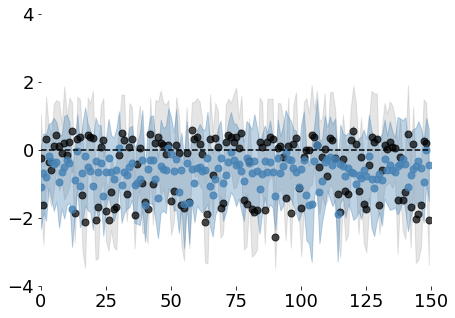

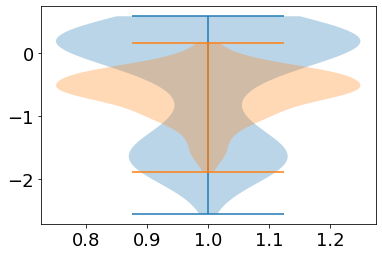

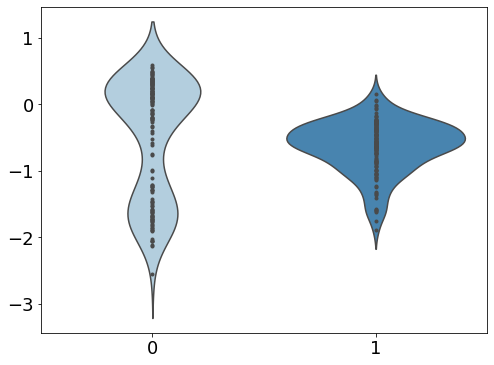

In [ ]:
#PLOTTING LYAPUNIV EXPONNETS
import random
random.shuffle(lyapunov_homo)
random.shuffle(lyapunov_hetero)



configurations = np.arange(0,Q,1)


plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 18})
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.plot(configurations,lyapunov_homo,'o',color='Black', markersize=7, alpha=0.7)
plt.plot(configurations,lyapunov_hetero,'o',  color='steelblue',alpha=0.8, markersize=7)
# plt.plot(configurations,lyapunov,'o',  color ='steelblue', markersize=12, alpha=0.8)
plt.plot(configurations,np.zeros(len(configurations)),"--", color='black')
plt.fill_between(configurations, lyapunov_homo - np.sqrt(time_var_lyapunov_homo), lyapunov_homo + np.sqrt(time_var_lyapunov_homo),
                 color='gray', alpha=0.2)
plt.fill_between(configurations, lyapunov_hetero - np.sqrt(time_var_lyapunov_hetero), lyapunov_hetero + np.sqrt(time_var_lyapunov_hetero),
                 color='steelblue', alpha=0.35)
plt.ylim(-4,4)
# plt.xscale("log")
plt.xlim(0, Q)
plt.show()
# plt.violinplot(lyapunov_homo)
# plt.violinplot(lyapunov_hetero)

# data = [lyapunov_homo,lyapunov_hetero]
# plt.figure(figsize=(8,6))
# my_pal = {"versicolor": "g", "setosa": "b"}
# sns.violinplot(data=[lyapunov_homo,lyapunov_hetero],inner="points",palette="Blues")
